# WEP Source Selection With WCS

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2023-12-12**
<br>Software Versions:
  - `ts_wep`: **v8.0.3**
  - `lsst_distrib`: **w_2023_47**

## Notebook Objective

This notebooks shows how to use the `generateDonutCatalogWcsTask` to create donut catalogs with a WCS available. It also shows how to configure the task with different source selector configurations. Finally, it shows how this task can be run as a part of a Gen 3 middleware pipeline.

## Logistics

This notebook is intended to be run on the USDF RSP: https://usdf-rsp.slac.stanford.edu/.

### Data

The images for this notebook were created by from imSim simulations of the LSSTCam Corner Wavefront Sensors (CWFS) using the Pan-Starrs reference catalog (`ps1_pv3_3pi_20170110`) available in `/sdf/group/rubin/datasets/refcats/htm/v1` on the USDF. The raw imSim outputs including the OPD for analysis are found at `/sdf/home/b/brycek/u/aos-repos/aosTestDataRepoImsim/simulated_data`.

## Imports

In [1]:
from lsst.daf.butler import Butler
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig

import lsst.geom
from lsst.ts.wep.utils import runProgram, writePipetaskCmd
from lsst.ts.wep.task import RefCatalogInterface
from lsst.ts.wep.task import GenerateDonutCatalogWcsTaskConfig, GenerateDonutCatalogWcsTask
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE

import matplotlib.pyplot as plt
%matplotlib inline

## Create `donutCatalog` as a single task before pipeline

In [2]:
# Repository with the raw data
butler_repo = '/sdf/group/rubin/u/brycek/aos-repos/aosTestDataRepoImsim/'

### Configure the `generateDonutCatalogWcsTask`

In [3]:
# Initialize Configuration
config = GenerateDonutCatalogWcsTaskConfig()

In [4]:
# Look at initial configuration
print(config)
print(config.keys())

{'saveMetadata': True, 'saveLogOutput': True, 'donutSelector': {'xCoordField': 'centroid_x', 'yCoordField': 'centroid_y', 'useCustomMagLimit': False, 'magMax': 99.0, 'magMin': -99.0, 'maxFieldDist': 1.813, 'unblendedSeparation': 160, 'minBlendedSeparation': 120, 'isolatedMagDiff': 2.0, 'sourceLimit': -1, 'maxBlended': 0}, 'doDonutSelection': True, 'anyFilterMapsToThis': None, 'connections': {'refCatalogs': 'cal_ref_cat', 'exposure': 'postISRCCD', 'donutCatalog': 'donutCatalog'}}
dict_keys(['saveMetadata', 'saveLogOutput', 'donutSelector', 'doDonutSelection', 'anyFilterMapsToThis', 'connections'])


* `donutSelector`:

  * This is the subtask that performs cuts on the sources detected to get our donut sources.
  * This task is activated with `doDonutSelection`.
  * The default settings have `unblendedSeparation` equal to 160. This means that sources will be tagged as unblended as long as they are 160 pixels from another source within the `isolatedMagDiff`. The `isolatedMagDiff` default is 2.0. This means that if multiple sources are within the `unblendedSeparation` of each other but the brightest is at least `isolatedMagDiff` brighter in the given filter than any of the others we will consider the brightest source unblended.
  * Here we will set a maximum number of sources to return in the catalog with `sourceLimit`. This will return the `n` brightest, unblended sources within our catalog settings up to `n = sourceLimit`. If `sourceLimit` is set to -1 (which is the default) then it will return all sources.
  * Finally we also set the number of stars that we will accept to be blended with the brightest star in a group (remember blended means the stars are within `unblendedSeparation` pixels of one another and their magnitudes are within `isolatedMagDiff`). When we set this config `maxBlended` to 0 we only accept unblended, isolated stars.

In [5]:
# Activate the subtask
config.doDonutSelection = True
# Turn on custom mag limits
config.donutSelector.useCustomMagLimit = True
# Set magnitude limits
config.donutSelector.magMax = 17.
config.donutSelector.magMin = 13.
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
config.donutSelector.isolatedMagDiff = 2.0
# Set the donut radius
config.donutSelector.unblendedSeparation = 160
# Set source limit
config.donutSelector.sourceLimit = 3
# Set the number of stars that can be blended with a star. A value of 0 here means we only take unblended stars.
config.donutSelector.maxBlended = 0
# Set the maximum distance (in degrees) a source can be from the center of the focal plane. This allows us
# to prevent vignetted sources from appearing in the catalog.
config.donutSelector.maxFieldDist = 1.85

## Create donut source catalogs

### Configure reference catalog input

Here we use the pointing information to only load the pieces of the reference catalog that cover the area of the sky in our field of view.

In [6]:
# Initialize with pointing information
boresightRa = 197.46
boresightDec = 24.33
# boresightRoAng is set to match the parallactic angle and line up
# with the telescope with camera rotation angle = 0.
boresightRotAng = 67.179 
refCatInterface = RefCatalogInterface(boresightRa, boresightDec, boresightRotAng)

#### Get `shardIds` for pointing

In [7]:
%%time
htmIds = refCatInterface.getHtmIds()

CPU times: user 105 µs, sys: 15 µs, total: 120 µs
Wall time: 122 µs


In [8]:
htmIds

array([223876, 223889, 223890, 223891, 223896, 223897, 223898, 223899,
       223900, 223901, 223902, 223903, 223928, 223929, 223931, 224328,
       224353, 224356, 224358, 224359, 224366, 224372, 223877, 223878,
       223879, 223888, 223893, 223894, 223895, 223922, 223930, 223932,
       223933, 223935, 223952, 223954, 223955, 223961, 223965, 224329,
       224330, 224331, 224352, 224354, 224355, 224357, 224364, 224365,
       224367, 224373, 224374, 224375, 224382])

#### Get butler data references for the pieces of the reference catalogs we want

In [9]:
butler = Butler(butler_repo)
# Find the collection that holds the reference catalogs
list(butler.registry.queryCollections())

['refcats/ps1_pv3_3pi_20170110',
 'refcats/gaia_dr2_20200414',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'LSSTCam/calib/curated/19700101T000000Z',
 'LSSTCam/raw/all',
 'ts_wep_v8.0.3',
 'refcats']

In [10]:
collections = ['refcats/ps1_pv3_3pi_20170110']

In [11]:
%%time
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
catalogName = 'ps1_pv3_3pi_20170110'
dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)

CPU times: user 172 ms, sys: 19.1 ms, total: 191 ms
Wall time: 287 ms


In [12]:
# The butler dataset references for the pieces of the reference catalog we want
dataRefs[:5]

[DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f384d84e410>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223876}, run='refcats/ps1_pv3_3pi_20170110', id=86815f9e-0b31-4e7b-b05b-09d7eaa035c2), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f384d84e410>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223889}, run='refcats/ps1_pv3_3pi_20170110', id=eff4cd62-9661-472a-8152-9bd6f13299e1), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler object at 0x7f384d84e410>, ref=DatasetRef(DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog), {htm7: 223890}, run='refcats/ps1_pv3_3pi_20170110', id=90e2ecd2-65cb-4e94-b5b1-e122c573d75d), parameters=None, storageClass=None),
 DeferredDatasetHandle(butler=<lsst.daf.butler.direct_butler.DirectButler objec

### Run ISR and get images

Before we go any further let's process some images so we can plot our catalogs on the images and see what our results look like at each step.

In [13]:
isrConfig = IsrTaskConfig()

In [14]:
isrConfig.doBias = False
isrConfig.doVariance = False
isrConfig.doLinearize = False
isrConfig.doCrosstalk = False
isrConfig.doDefect = False
isrConfig.doNanMasking = False
isrConfig.doInterpolate = False
isrConfig.doDark = False
isrConfig.doFlat = False
isrConfig.doApplyGains = True
isrConfig.doFringe = False
isrConfig.doOverscan = True

In [15]:
isrTask = IsrTask(config=isrConfig)

In [16]:
cwfsDataIdsExtra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=195, instrument='LSSTCam'))

In [17]:
cwfsDataIdsExtra

[{instrument: 'LSSTCam', detector: 195, exposure: 5022050101000, band: 'g', physical_filter: 'g_6'}]

In [18]:
cwfsDataIdsIntra = list(butler.registry.queryDataIds(['exposure', 'detector', 'instrument'], detector=196, instrument='LSSTCam'))

In [19]:
cwfsDataIdsIntra

[{instrument: 'LSSTCam', detector: 196, exposure: 5022050101000, band: 'g', physical_filter: 'g_6'}]

In [20]:
exposureExtra = butler.get('raw', dataId=cwfsDataIdsExtra[0], collections=['LSSTCam/raw/all'])

In [21]:
exposureIntra = butler.get('raw', dataId=cwfsDataIdsIntra[0], collections=['LSSTCam/raw/all'])

In [22]:
isrOutExtra = isrTask.run(exposureExtra)

In [23]:
isrOutIntra = isrTask.run(exposureIntra)

### Running with the initial catalog configuration

In [24]:
# Run task
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [25]:
catExtra = catCreationTask.run(dataRefs, isrOutExtra.exposure)

Text(0, 0.5, 'Y Position (Pixels)')

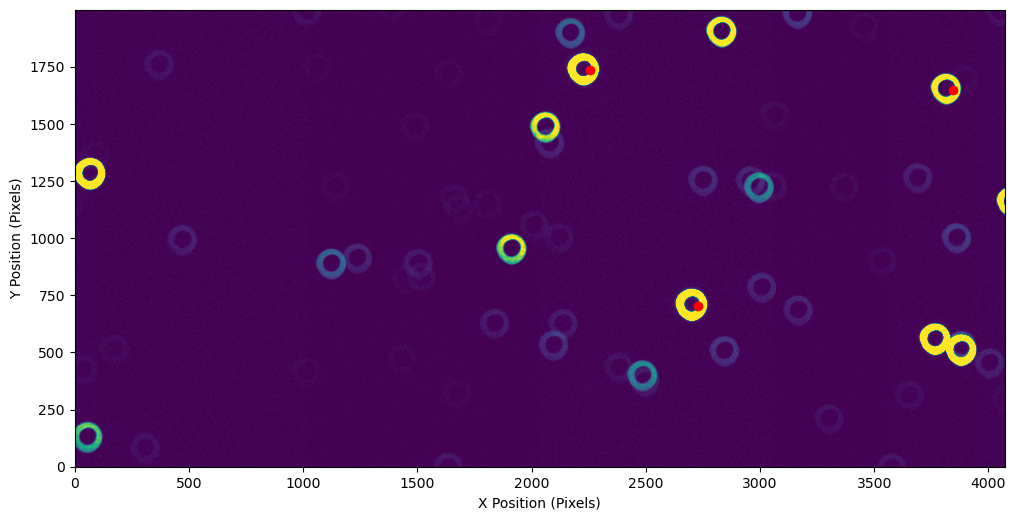

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=200, vmin=0, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.xlabel('X Position (Pixels)')
plt.ylabel('Y Position (Pixels)')

### Show that our catalog changes as we change configurations

Let's change the configuration settings and see how our catalog changes.

#### Remove limit on number of sources

In [27]:
# Create task with our configuration from above but first turn off the sourceLimit parameter (set to -1).
config.donutSelector.sourceLimit = -1
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [28]:
%%time
catExtraNoSourceLimit = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 123 ms, sys: 2.95 ms, total: 126 ms
Wall time: 129 ms


In [29]:
catExtraNoSourceLimit.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2730.245615,704.660863,1.390237e+07,[],[]
1,3.416295,0.435093,2256.459628,1736.348839,1.179842e+07,[],[]
2,3.414778,0.434399,3843.944733,1647.948737,1.590008e+06,[],[]
3,3.416566,0.434932,2090.341997,1483.469047,1.052163e+06,[],[]
4,3.416938,0.434516,1942.447064,950.211746,9.297410e+05,[],[]


We see that we now have two more sources than we had when we limited the length of the returned catalog.

Text(0, 0.5, 'Y Position (Pixels)')

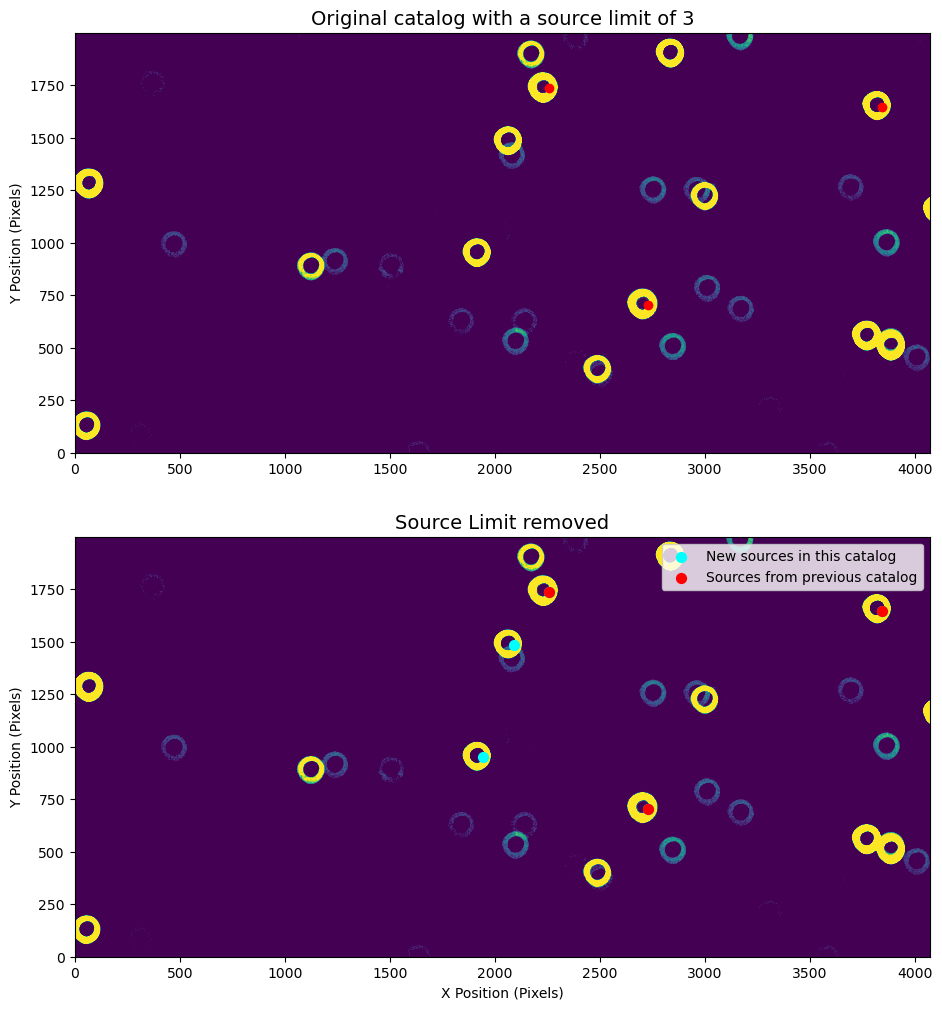

In [30]:
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(2,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(2,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Source Limit removed', size=14)
plt.xlabel('X Position (Pixels)')
plt.ylabel('Y Position (Pixels)')

Notice how the sources kept with the `sourceLimit` are the `sourceLimit` brightest sources.

#### Change magnitude limits

In [31]:
# Change magMax value to 19.0 from 17.0
config.donutSelector.magMax = 19.0
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [32]:
%%time
catExtraMagLimit19 = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 122 ms, sys: 6.98 ms, total: 129 ms
Wall time: 131 ms


In [33]:
catExtraMagLimit19.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2730.245615,704.660863,1.390237e+07,[],[]
1,3.416295,0.435093,2256.459628,1736.348839,1.179842e+07,[],[]
2,3.414778,0.434399,3843.944733,1647.948737,1.590008e+06,[],[]
3,3.416566,0.434932,2090.341997,1483.469047,1.052163e+06,[],[]
4,3.416938,0.434516,1942.447064,950.211746,9.297410e+05,[],[]
5,3.416613,0.433801,2515.606585,395.051255,4.340326e+05,[],[]
6,3.415012,0.433800,3890.277981,994.038568,1.512020e+05,[],[]
7,3.416217,0.433757,2873.715789,501.270568,1.376093e+05,[],[]
8,3.415991,0.434456,2780.335788,1247.472294,1.088828e+05,[],[]
9,3.415939,0.433939,3037.761166,778.356390,9.551228e+04,[],[]


Now we have a lot more sources. Let's check the magnitudes from each catalog to make sure the cuts are correct.

In [34]:
import numpy as np
import astropy.units as u
origCatalogMags = (catExtraNoSourceLimit.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)
newCatalogMags = (catExtraMagLimit19.donutCatalog['source_flux'].values * u.nJy).to_value(u.ABmag)

In [35]:
print(f"The original catalog had stars with magnitudes between {np.min(origCatalogMags)} and {np.max(origCatalogMags)}.\nThese are within the limits of 13.0 - 17.0 set by the task configuration.")

The original catalog had stars with magnitudes between 13.542277683868818 and 16.479095093743577.
These are within the limits of 13.0 - 17.0 set by the task configuration.


In [36]:
print(f"The new catalog has stars with magnitudes between {np.min(newCatalogMags)} and {np.max(newCatalogMags)}.\nThese are within the limits of 13.0 - 19.0 set by the task configuration.")

The new catalog has stars with magnitudes between 13.542277683868818 and 18.97681224516664.
These are within the limits of 13.0 - 19.0 set by the task configuration.


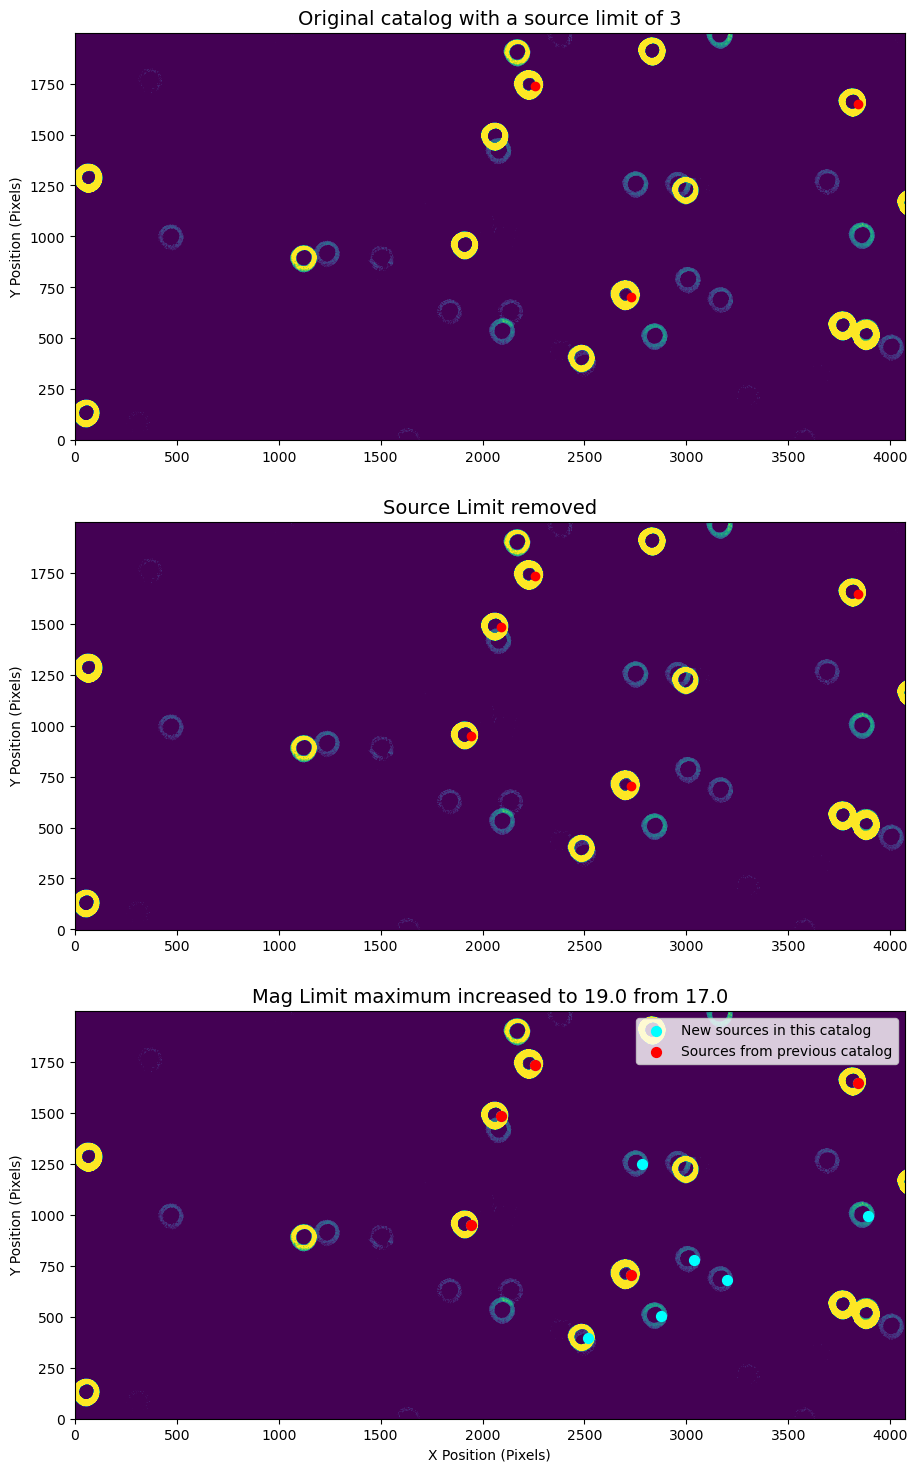

In [37]:
fig = plt.figure(figsize=(12, 18))
fig.add_subplot(3,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(3,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(3,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')
plt.legend()

#### Change isolated magnitude setting

Let's call stars unblended now if they are only 1 magnitude brighter than any overlapping stars.

In [38]:
# Change isoMagDiff to shrink the threshold for unblended down to only 1 magnitude brighther than overlapping stars
config.donutSelector.isolatedMagDiff = 1.0
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [39]:
%%time
catExtraIsoOneMag = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 125 ms, sys: 3.01 ms, total: 128 ms
Wall time: 144 ms


In [40]:
catExtraIsoOneMag.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2730.245615,704.660863,1.390237e+07,[],[]
1,3.416295,0.435093,2256.459628,1736.348839,1.179842e+07,[],[]
2,3.414778,0.434399,3843.944733,1647.948737,1.590008e+06,[],[]
3,3.416566,0.434932,2090.341997,1483.469047,1.052163e+06,[],[]
4,3.416938,0.434516,1942.447064,950.211746,9.297410e+05,[],[]
5,3.415763,0.434334,3025.472544,1217.494642,4.393951e+05,[],[]
6,3.416613,0.433801,2515.606585,395.051255,4.340326e+05,[],[]
7,3.417739,0.434764,1152.871677,886.138978,2.976980e+05,[],[]
8,3.415012,0.433800,3890.277981,994.038568,1.512020e+05,[],[]
9,3.416217,0.433757,2873.715789,501.270568,1.376093e+05,[],[]


This setting allowed two more stars to pass through into our catalog.

Text(0.5, 0, 'X Position (Pixels)')

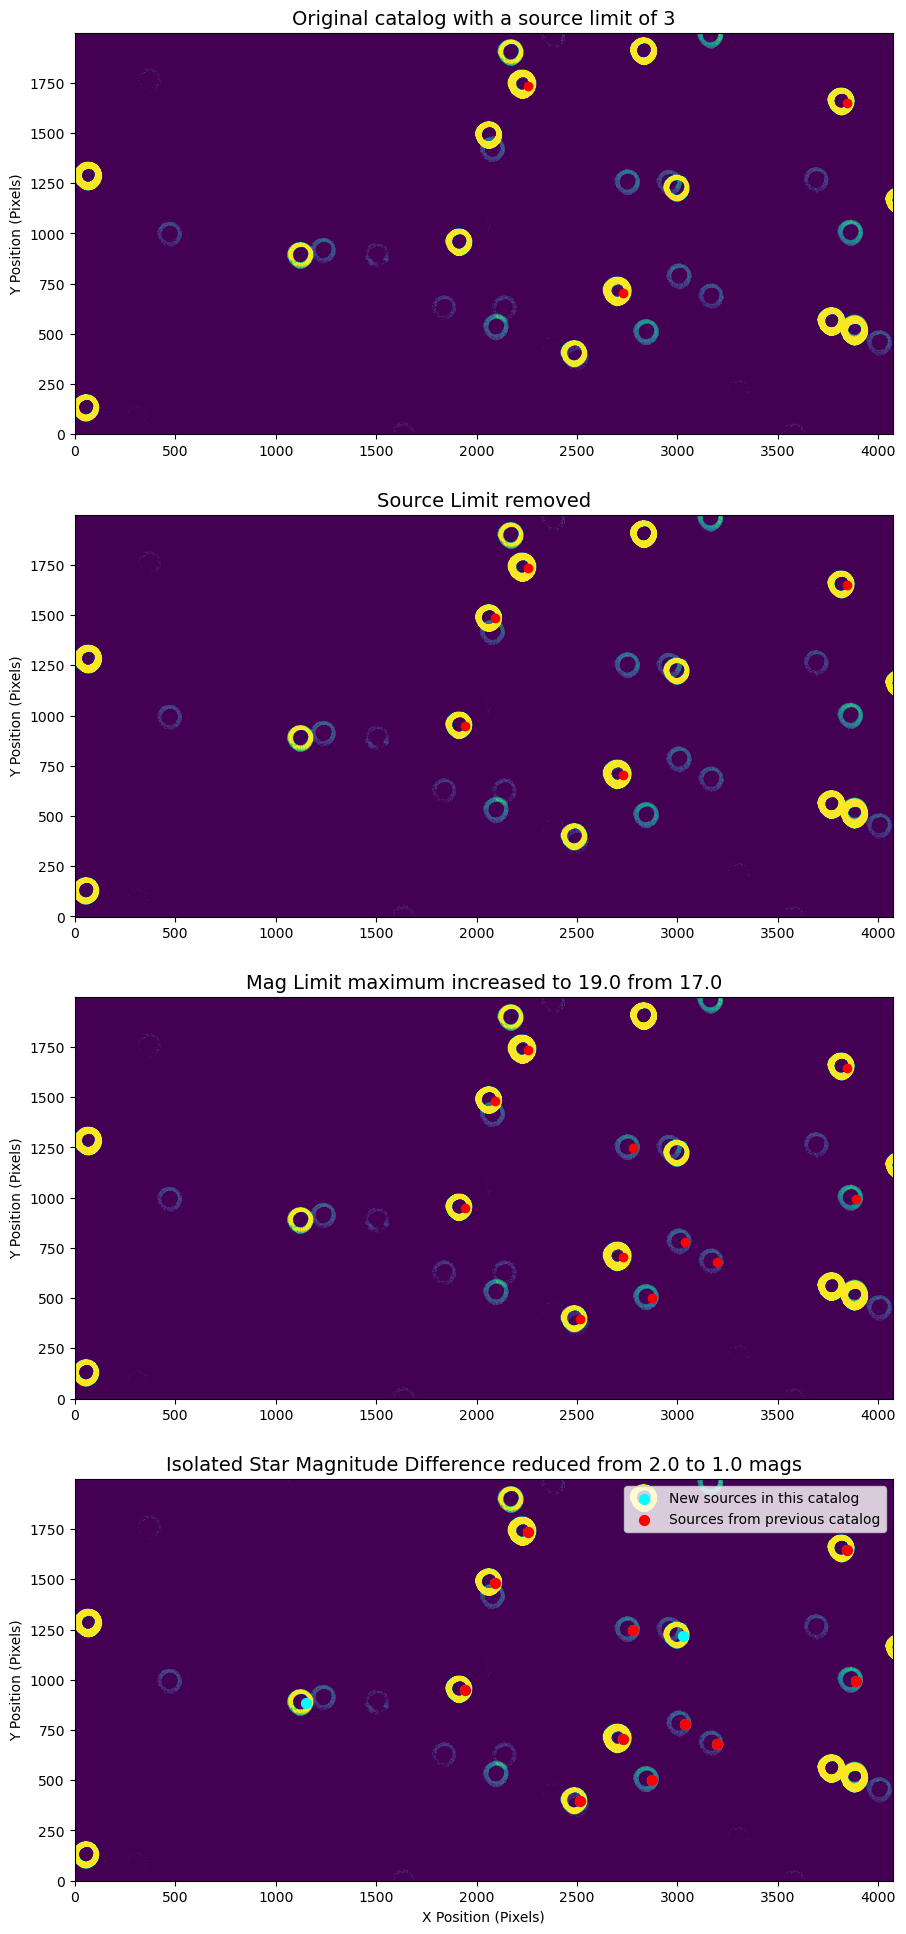

In [41]:
fig = plt.figure(figsize=(12, 24))
fig.add_subplot(4,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(4,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

#### Change number of allowed blended stars

Finally allow stars blended with only one other star within the `unblendedSeparation` and `isolatedMagDiff` settings.

In [42]:
# Change number of allowed stars blended with a target star to be 1 instead of 0
config.donutSelector.maxBlended = 1
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [43]:
%%time
catExtraOneBlend = catCreationTask.run(dataRefs, isrOutExtra.exposure)

CPU times: user 126 ms, sys: 3.08 ms, total: 129 ms
Wall time: 140 ms


In [44]:
catExtraOneBlend.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.416271,0.433993,2730.245615,704.660863,1.390237e+07,[],[]
1,3.416295,0.435093,2256.459628,1736.348839,1.179842e+07,[],[]
2,3.415293,0.433445,3796.135459,552.532931,4.951916e+06,[3911.069615045997],[520.4753277322147]
3,3.414778,0.434399,3843.944733,1647.948737,1.590008e+06,[],[]
4,3.416566,0.434932,2090.341997,1483.469047,1.052163e+06,[],[]
5,3.416938,0.434516,1942.447064,950.211746,9.297410e+05,[],[]
6,3.415763,0.434334,3025.472544,1217.494642,4.393951e+05,[],[]
7,3.416613,0.433801,2515.606585,395.051255,4.340326e+05,[],[]
8,3.417739,0.434764,1152.871677,886.138978,2.976980e+05,[],[]
9,3.415012,0.433800,3890.277981,994.038568,1.512020e+05,[],[]


Once again another source appears in our catalog.

Text(0.5, 0, 'X Position (Pixels)')

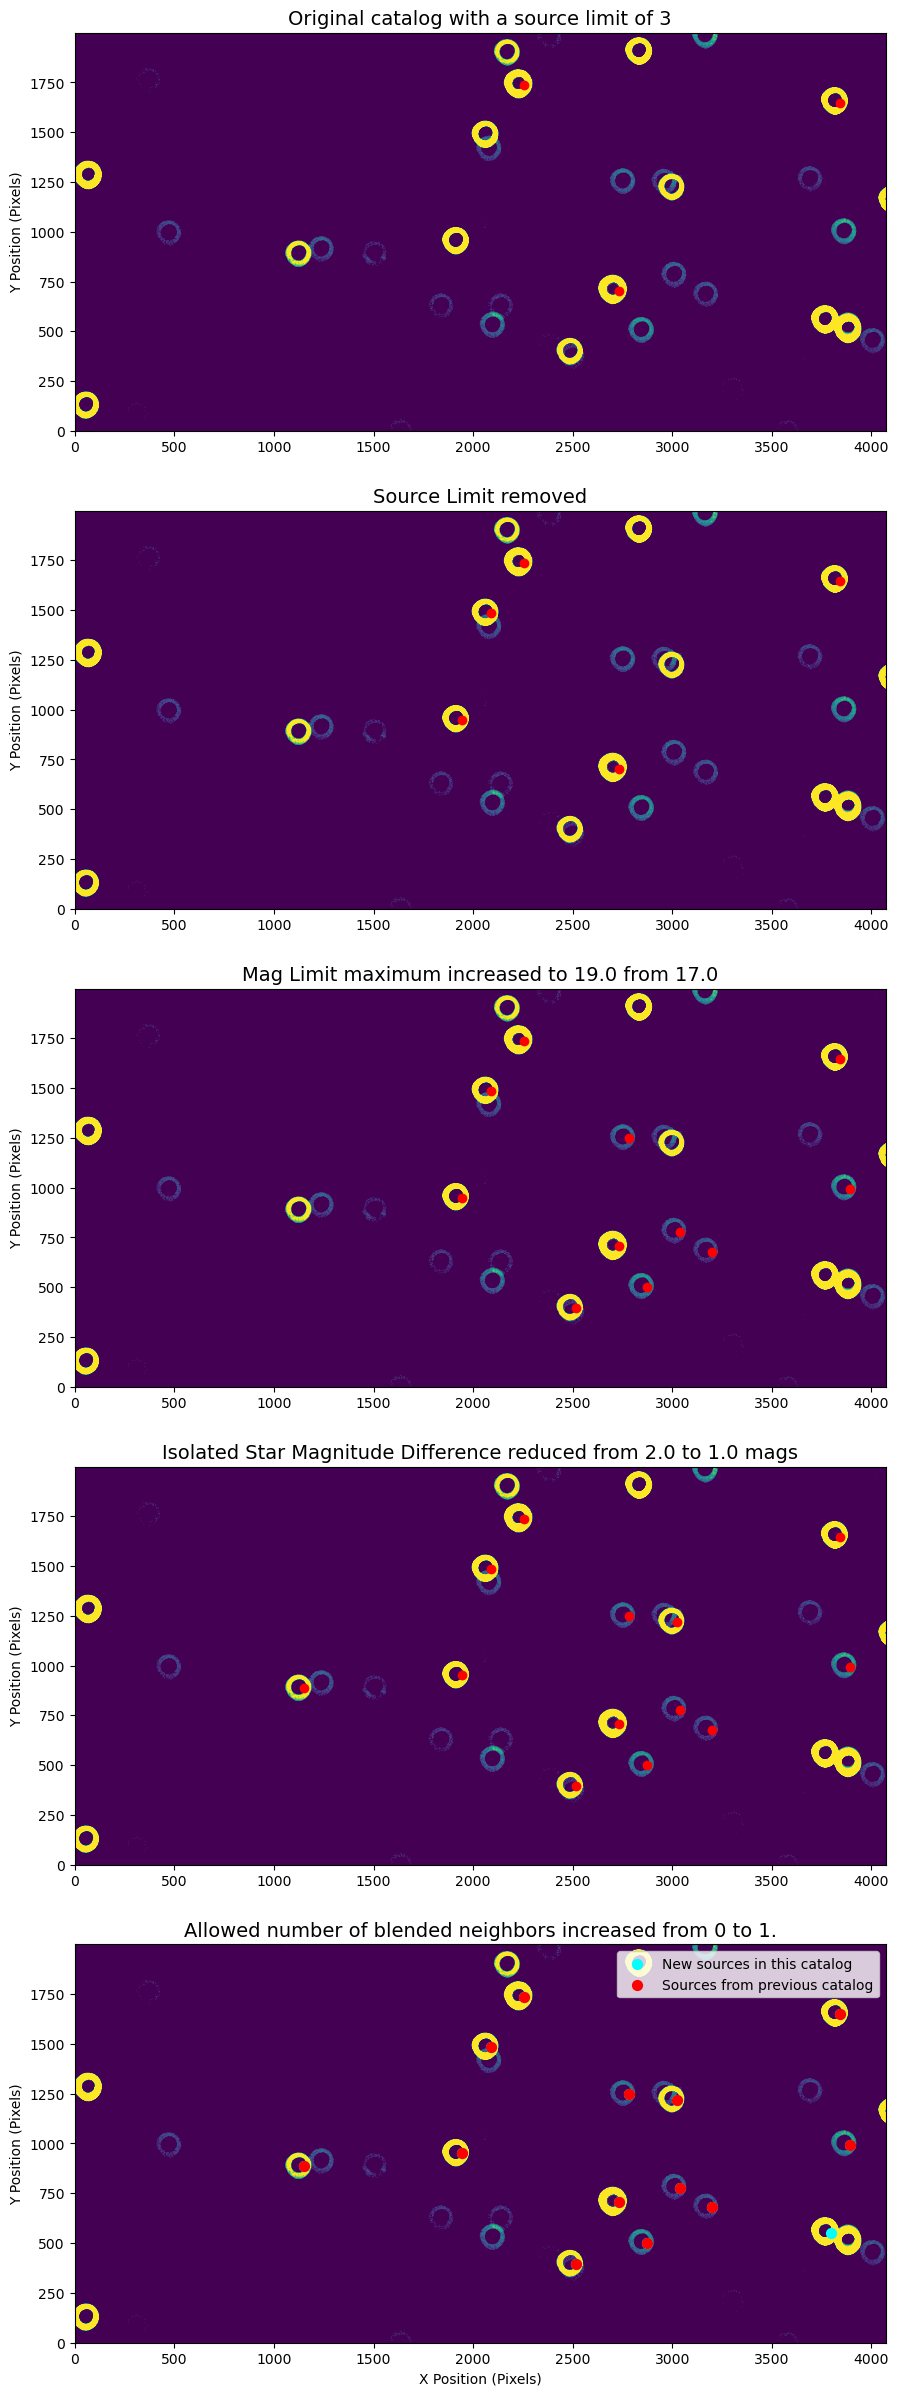

In [45]:
fig = plt.figure(figsize=(12, 30))
fig.add_subplot(5,1,1)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtra.donutCatalog['centroid_x'], catExtra.donutCatalog['centroid_y'], c='r')
plt.title('Original catalog with a source limit of 3', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,2)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraNoSourceLimit.donutCatalog['centroid_x'], catExtraNoSourceLimit.donutCatalog['centroid_y'], c='r')
plt.title('Source Limit removed', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,3)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraMagLimit19.donutCatalog['centroid_x'], catExtraMagLimit19.donutCatalog['centroid_y'], c='r')
plt.title('Mag Limit maximum increased to 19.0 from 17.0', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,4)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r')
plt.title('Isolated Star Magnitude Difference reduced from 2.0 to 1.0 mags', size=14)
plt.ylabel('Y Position (Pixels)')

fig.add_subplot(5,1,5)
plt.imshow(isrOutExtra.exposure.getImage().getArray(), vmax=50, vmin=10, origin='lower')
plt.scatter(catExtraOneBlend.donutCatalog['centroid_x'], catExtraOneBlend.donutCatalog['centroid_y'], c='cyan', s=50, label='New sources in this catalog')
plt.scatter(catExtraIsoOneMag.donutCatalog['centroid_x'], catExtraIsoOneMag.donutCatalog['centroid_y'], c='r', s=50, label='Sources from previous catalog')
plt.legend()
plt.title('Allowed number of blended neighbors increased from 0 to 1.', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

#### Change allowed distance from center of the focal plane

Here we will look at the intra-focal detector and how we can limit donuts chosen to only be within a certain distance from the center of the focal plane. We want to be able to do this to avoid vignetted donuts in our catalogs if they turn out to cause issues with wavefront estimation.

In [46]:
# Create task with our final configuration from the extra-focal detector that allows a large sample of sources.
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [47]:
%%time
catIntraBaseline = catCreationTask.run(dataRefs, isrOutIntra.exposure)

CPU times: user 61.5 ms, sys: 112 µs, total: 61.7 ms
Wall time: 61.8 ms


In [48]:
catIntraBaseline.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.417718,0.436853,3761.264999,1455.609215,4.787356e+06,[],[]
1,3.415339,0.435769,1275.298415,1592.619435,4.623140e+06,[],[]
2,3.414932,0.435764,923.408008,1444.528485,3.504352e+06,[],[]
3,3.416469,0.436226,2432.102561,1582.596075,3.496992e+06,[],[]
4,3.415768,0.436450,1923.925363,1108.835571,2.631190e+06,[],[]
5,3.415946,0.437505,2511.008074,177.134858,2.608572e+06,[],[]
6,3.415054,0.437140,1595.612579,189.106523,1.105726e+06,[],[]
7,3.416633,0.437488,3093.022453,450.291729,7.907617e+05,[],[]
8,3.415363,0.436489,1591.967608,920.538210,5.054894e+05,[],[]
9,3.416510,0.437359,2934.044857,526.453285,3.349112e+05,[],[]


We see that we have 13 sources in our baseline catalog. Now let's run the task limiting our sources to be within 1.75 degrees of the center of the focal plane.

In [49]:
# Create task with our final configuration from the extra-focal detector that allows a large sample of sources.
config.donutSelector.maxFieldDist = 1.75
catCreationTask = GenerateDonutCatalogWcsTask(config=config)

In [50]:
%%time
catIntra1p75degrees = catCreationTask.run(dataRefs, isrOutIntra.exposure)

CPU times: user 58.4 ms, sys: 1.01 ms, total: 59.4 ms
Wall time: 59.6 ms


In [51]:
catIntra1p75degrees.donutCatalog

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,3.417718,0.436853,3761.264999,1455.609215,4.787356e+06,[],[]
1,3.415339,0.435769,1275.298415,1592.619435,4.623140e+06,[],[]
2,3.416469,0.436226,2432.102561,1582.596075,3.496992e+06,[],[]
3,3.415768,0.436450,1923.925363,1108.835571,2.631190e+06,[],[]
4,3.415946,0.437505,2511.008074,177.134858,2.608572e+06,[],[]
5,3.416633,0.437488,3093.022453,450.291729,7.907617e+05,[],[]
6,3.415363,0.436489,1591.967608,920.538210,5.054894e+05,[],[]
7,3.416510,0.437359,2934.044857,526.453285,3.349112e+05,[],[]
8,3.415592,0.436552,1814.662039,946.255664,2.348644e+05,[],[]
9,3.416188,0.437008,2513.170559,737.681521,1.368089e+05,[2587.124038155312],[626.6728387684403]


Now our catalog only has 10 sources that are within 1.75 degrees of the center of the focal plane. To verify that this is correct let's draw out the distance from the center of the focal plane as a series of contours and check that we have no sources outside 1.75 degrees from the center.

In [52]:
# Create meshgrid for contours and calculate distance to center for points in grid

X, Y = np.meshgrid(np.arange(0, 4096, 5), np.arange(0, 2001, 5))
Z = np.zeros(np.shape(X))

for x_idx in np.arange(0, 4096, 5):
    for y_idx in np.arange(0, 2001, 5):
        # Use detector object to convert between Pixels and Field Angle
        field_xy = isrOutIntra.exposure.getDetector().transform(
            lsst.geom.Point2D(x_idx, y_idx), PIXELS, FIELD_ANGLE
        )
        field_dist = np.sqrt(field_xy[0]**2 + field_xy[1]**2)
        Z[int(y_idx/5), int(x_idx/5)] = np.degrees(field_dist)

Text(0.5, 0, 'X Position (Pixels)')

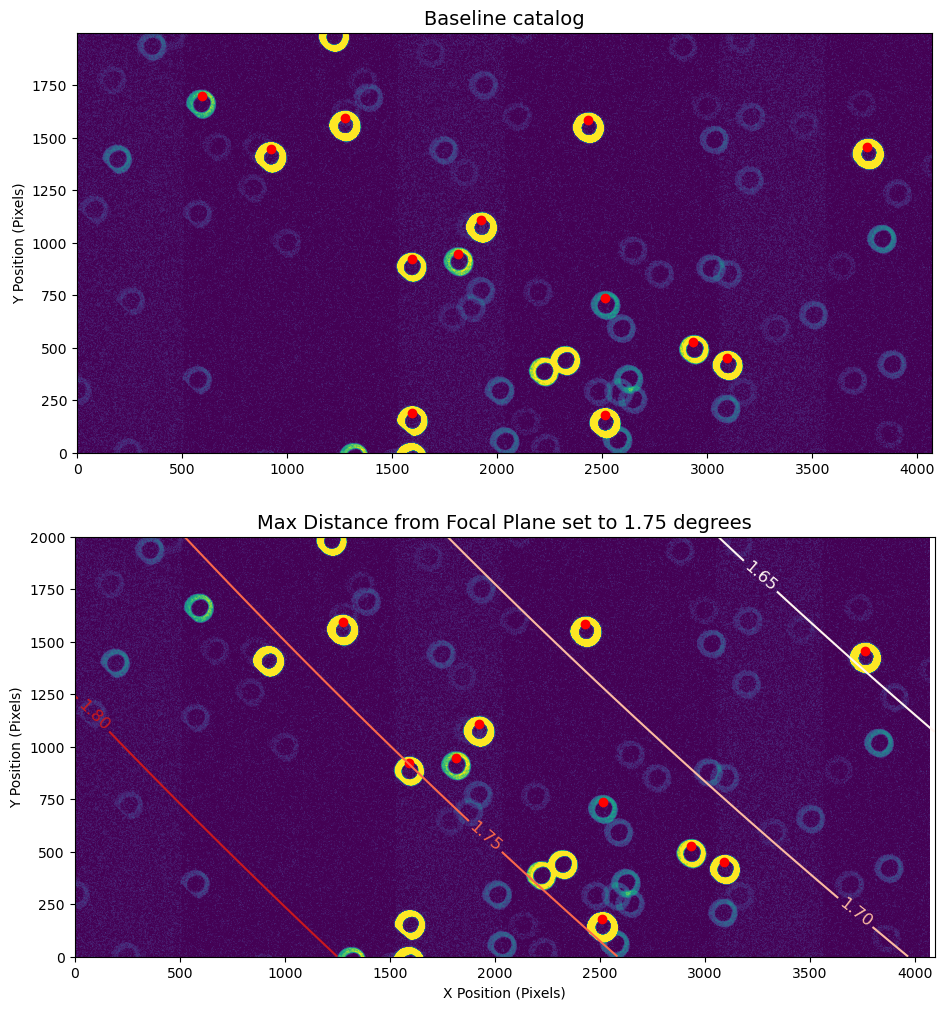

In [53]:
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(2,1,1)
plt.imshow(isrOutIntra.exposure.getImage().getArray(), vmax=50, vmin=0, origin='lower')
plt.scatter(catIntraBaseline.donutCatalog['centroid_x'], catIntraBaseline.donutCatalog['centroid_y'], c='r')
plt.title('Baseline catalog', size=14)
plt.ylabel('Y Position (Pixels)')

ax = fig.add_subplot(2,1,2)
plt.imshow(isrOutIntra.exposure.getImage().getArray(), vmax=50, vmin=0, origin='lower')
C = plt.contour(X, Y, Z, cmap=plt.get_cmap('Reds'), levels=[1.65, 1.70, 1.75, 1.80, 1.85])
ax.clabel(C, inline=True, fontsize=12)
plt.scatter(catIntra1p75degrees.donutCatalog['centroid_x'], catIntra1p75degrees.donutCatalog['centroid_y'], c='r')
plt.title('Max Distance from Focal Plane set to 1.75 degrees', size=14)
plt.ylabel('Y Position (Pixels)')
plt.xlabel('X Position (Pixels)')

It looks like our sources are all the sources within the cutoff at 1.75 degrees and that the configuration setting is working as expected.

## Running as a pipeline task

Here in this example notebook we showed how to run the `GenerateDonutCatalogWcsTask` in individual steps. When running in a full Gen3 processing pipeline you can use `GenerateDonutCatalogWcsTask` setting the configuration settings for source selection in a pipeline file or on the command line.

A sample pipeline configuration file to run the `isrTask` and `generateDonutCatalogWcsTask` from this notebook might look like this:
```
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline to run donut source selection using ts_wep
description: wep sample source selection pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    # Here we specify the configurations for pointing that we added into the class
    # GenerateDonutCatalogWcsTaskConfig.
    config:
      connections.refCatalogs: 'ps1_pv3_3pi_20170110'
      doDonutSelection: True
      donutSelector.useCustomMagLimit: True
      donutSelector.magMax: 17.0
```

And a possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection